In [3]:
import pandas as pd
from mainnet_launch.constants import (
    CACHE_TIME,
    eth_client,
    ALL_AUTOPOOLS,
    BAL_ETH,
    AUTO_ETH,
    AUTO_LRT,
    AutopoolConstants,
)
from mainnet_launch.destinations import get_destination_details
from mainnet_launch.lens_contract import get_pools_and_destinations_call
from mainnet_launch.destination_diagnostics.fetch_destination_summary_stats import _build_summary_stats_call

import warnings

warnings.filterwarnings("ignore", message=".*This warning can be ignored when running in bare mode*")

destination_details = get_destination_details()

2024-10-28 15:19:17.976 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2024-10-28 15:19:17.980 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2024-10-28 15:19:17.982 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2024-10-28 15:19:18.060 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2024-10-28 15:19:18.062 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-28 15:19:18.119 
  command:

    streamlit run /home/parker/Documents/Tokemak/v2-rebalance-dashboard/.venv/lib/python3.10/site-packages/ipykernel_launcher.py [ARGUMENTS]
2024-10-28 15:19:18.119 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-2

In [4]:
suspect_pool = destination_details[0]
suspect_pool

Destination Details:
 vaultAddress	: 0x2F7e096a400ded5D02762120b39A3aA4ABA072a4
 exchangeName	: balancer
 dexPool	: 0x7761b6E0Daa04E70637D81f1Da7d186C205C2aDE
 lpTokenAddress	: 0x7761b6E0Daa04E70637D81f1Da7d186C205C2aDE
 lpTokenSymbol	: rsETH / ETHx
 lpTokenName	: Balancer rsETH / ETHx
 autopool	: {'name': 'Balancer/Tokemak balETH', 'autopool_eth_addr': '0x6dC3ce9C57b20131347FDc9089D740DAf6eB34c5', 'autopool_eth_strategy_addr': '0xabe104560D0B390309bcF20b73Dca335457AA32e', 'solver_rebalance_plans_bucket': 'v2-gen3-eth-mainnet-solve-v2gen3ethmainnetsolverba-wx1snhldrupb'}
 vault_name	: rsETH / ETHx (balancer)

In [5]:
from multicall import Call

from mainnet_launch.constants import CACHE_TIME, ALL_AUTOPOOLS, eth_client, LENS_CONTRACT
from mainnet_launch.data_fetching.get_state_by_block import (
    get_raw_state_by_blocks,
    get_state_by_one_block,
    identity_with_bool_success,
    safe_normalize_with_bool_success,
    build_blocks_to_use,
)


def build_get_virtual_price_call(name: str, curve_pool) -> Call:
    return Call(
        curve_pool,
        ["get_virtual_price()(uint256)"],
        [(name, safe_normalize_with_bool_success)],
    )


blocks = build_blocks_to_use(use_mainnet=False)
df = get_raw_state_by_blocks([build_get_virtual_price_call("virtual_price", suspect_pool.lpTokenAddress)], blocks)
df

2024-10-28 15:19:24.860 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-28 15:19:24.860 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-28 15:19:24.861 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


2024-10-28 15:19:24.970 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-28 15:19:24.971 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


,virtual_price
timestamp,
2024-07-08 14:38:47+00:00,None
2024-07-08 18:19:47+00:00,None
2024-07-08 22:01:47+00:00,None
2024-07-09 01:41:59+00:00,None
2024-07-09 05:21:59+00:00,None
...,...
2024-10-28 04:36:47+00:00,None
2024-10-28 08:17:35+00:00,None
2024-10-28 11:57:47+00:00,None


In [6]:
import plotly.express as px
import plotly.io as pio
import numpy as np

pio.templates.default = None
daily_df = df.resample("1D").last()
DEX_FEE_ALPHA = 0.1
daily_df["daily_apr_from_vp_change"] = (
    (daily_df["virtual_price"].diff(1) / daily_df["virtual_price"].shift(1)) * 365 * 100
)
daily_df = daily_df.dropna()

priorValue = 2.0  # a reasonable seed value


def get_smoothed_fee_apr(priorValue, currentValue):
    return (priorValue * (1 - DEX_FEE_ALPHA)) + (currentValue * DEX_FEE_ALPHA)


ewma_smoothed_fee_apr = []
for fee_apr_value in daily_df["daily_apr_from_vp_change"].values:
    new_prior = get_smoothed_fee_apr(priorValue, fee_apr_value)
    priorValue = new_prior
    ewma_smoothed_fee_apr.append(priorValue)


daily_df["ewma_smoothed_fee_apr"] = ewma_smoothed_fee_apr
px.line(daily_df[["daily_apr_from_vp_change", "ewma_smoothed_fee_apr"]])

TypeError: unsupported operand type(s) for -: 'NoneType' and 'NoneType'

In [13]:
import plotly.express as px

In [8]:
abi = """[{"name":"Transfer","inputs":[{"name":"sender","type":"address","indexed":true},{"name":"receiver","type":"address","indexed":true},{"name":"value","type":"uint256","indexed":false}],"anonymous":false,"type":"event"},{"name":"Approval","inputs":[{"name":"owner","type":"address","indexed":true},{"name":"spender","type":"address","indexed":true},{"name":"value","type":"uint256","indexed":false}],"anonymous":false,"type":"event"},{"name":"TokenExchange","inputs":[{"name":"buyer","type":"address","indexed":true},{"name":"sold_id","type":"int128","indexed":false},{"name":"tokens_sold","type":"uint256","indexed":false},{"name":"bought_id","type":"int128","indexed":false},{"name":"tokens_bought","type":"uint256","indexed":false}],"anonymous":false,"type":"event"},{"name":"AddLiquidity","inputs":[{"name":"provider","type":"address","indexed":true},{"name":"token_amounts","type":"uint256[2]","indexed":false},{"name":"fees","type":"uint256[2]","indexed":false},{"name":"invariant","type":"uint256","indexed":false},{"name":"token_supply","type":"uint256","indexed":false}],"anonymous":false,"type":"event"},{"name":"RemoveLiquidity","inputs":[{"name":"provider","type":"address","indexed":true},{"name":"token_amounts","type":"uint256[2]","indexed":false},{"name":"fees","type":"uint256[2]","indexed":false},{"name":"token_supply","type":"uint256","indexed":false}],"anonymous":false,"type":"event"},{"name":"RemoveLiquidityOne","inputs":[{"name":"provider","type":"address","indexed":true},{"name":"token_amount","type":"uint256","indexed":false},{"name":"coin_amount","type":"uint256","indexed":false},{"name":"token_supply","type":"uint256","indexed":false}],"anonymous":false,"type":"event"},{"name":"RemoveLiquidityImbalance","inputs":[{"name":"provider","type":"address","indexed":true},{"name":"token_amounts","type":"uint256[2]","indexed":false},{"name":"fees","type":"uint256[2]","indexed":false},{"name":"invariant","type":"uint256","indexed":false},{"name":"token_supply","type":"uint256","indexed":false}],"anonymous":false,"type":"event"},{"name":"RampA","inputs":[{"name":"old_A","type":"uint256","indexed":false},{"name":"new_A","type":"uint256","indexed":false},{"name":"initial_time","type":"uint256","indexed":false},{"name":"future_time","type":"uint256","indexed":false}],"anonymous":false,"type":"event"},{"name":"StopRampA","inputs":[{"name":"A","type":"uint256","indexed":false},{"name":"t","type":"uint256","indexed":false}],"anonymous":false,"type":"event"},{"name":"CommitNewFee","inputs":[{"name":"new_fee","type":"uint256","indexed":false}],"anonymous":false,"type":"event"},{"name":"ApplyNewFee","inputs":[{"name":"fee","type":"uint256","indexed":false}],"anonymous":false,"type":"event"},{"stateMutability":"nonpayable","type":"constructor","inputs":[],"outputs":[]},{"stateMutability":"nonpayable","type":"function","name":"initialize","inputs":[{"name":"_name","type":"string"},{"name":"_symbol","type":"string"},{"name":"_coins","type":"address[4]"},{"name":"_rate_multipliers","type":"uint256[4]"},{"name":"_A","type":"uint256"},{"name":"_fee","type":"uint256"}],"outputs":[]},{"stateMutability":"nonpayable","type":"function","name":"transfer","inputs":[{"name":"_to","type":"address"},{"name":"_value","type":"uint256"}],"outputs":[{"name":"","type":"bool"}]},{"stateMutability":"nonpayable","type":"function","name":"transferFrom","inputs":[{"name":"_from","type":"address"},{"name":"_to","type":"address"},{"name":"_value","type":"uint256"}],"outputs":[{"name":"","type":"bool"}]},{"stateMutability":"nonpayable","type":"function","name":"approve","inputs":[{"name":"_spender","type":"address"},{"name":"_value","type":"uint256"}],"outputs":[{"name":"","type":"bool"}]},{"stateMutability":"nonpayable","type":"function","name":"permit","inputs":[{"name":"_owner","type":"address"},{"name":"_spender","type":"address"},{"name":"_value","type":"uint256"},{"name":"_deadline","type":"uint256"},{"name":"_v","type":"uint8"},{"name":"_r","type":"bytes32"},{"name":"_s","type":"bytes32"}],"outputs":[{"name":"","type":"bool"}]},{"stateMutability":"view","type":"function","name":"last_price","inputs":[],"outputs":[{"name":"","type":"uint256"}]},{"stateMutability":"view","type":"function","name":"ema_price","inputs":[],"outputs":[{"name":"","type":"uint256"}]},{"stateMutability":"view","type":"function","name":"stored_rates","inputs":[],"outputs":[{"name":"","type":"uint256[2]"}]},{"stateMutability":"view","type":"function","name":"balances","inputs":[{"name":"i","type":"uint256"}],"outputs":[{"name":"","type":"uint256"}]},{"stateMutability":"view","type":"function","name":"admin_fee","inputs":[],"outputs":[{"name":"","type":"uint256"}]},{"stateMutability":"view","type":"function","name":"A","inputs":[],"outputs":[{"name":"","type":"uint256"}]},{"stateMutability":"view","type":"function","name":"A_precise","inputs":[],"outputs":[{"name":"","type":"uint256"}]},{"stateMutability":"view","type":"function","name":"get_p","inputs":[],"outputs":[{"name":"","type":"uint256"}]},{"stateMutability":"view","type":"function","name":"price_oracle","inputs":[],"outputs":[{"name":"","type":"uint256"}]},{"stateMutability":"view","type":"function","name":"get_virtual_price","inputs":[],"outputs":[{"name":"","type":"uint256"}]},{"stateMutability":"view","type":"function","name":"calc_token_amount","inputs":[{"name":"_amounts","type":"uint256[2]"},{"name":"_is_deposit","type":"bool"}],"outputs":[{"name":"","type":"uint256"}]},{"stateMutability":"payable","type":"function","name":"add_liquidity","inputs":[{"name":"_amounts","type":"uint256[2]"},{"name":"_min_mint_amount","type":"uint256"}],"outputs":[{"name":"","type":"uint256"}]},{"stateMutability":"payable","type":"function","name":"add_liquidity","inputs":[{"name":"_amounts","type":"uint256[2]"},{"name":"_min_mint_amount","type":"uint256"},{"name":"_receiver","type":"address"}],"outputs":[{"name":"","type":"uint256"}]},{"stateMutability":"view","type":"function","name":"get_dy","inputs":[{"name":"i","type":"int128"},{"name":"j","type":"int128"},{"name":"dx","type":"uint256"}],"outputs":[{"name":"","type":"uint256"}]},{"stateMutability":"payable","type":"function","name":"exchange","inputs":[{"name":"i","type":"int128"},{"name":"j","type":"int128"},{"name":"_dx","type":"uint256"},{"name":"_min_dy","type":"uint256"}],"outputs":[{"name":"","type":"uint256"}]},{"stateMutability":"payable","type":"function","name":"exchange","inputs":[{"name":"i","type":"int128"},{"name":"j","type":"int128"},{"name":"_dx","type":"uint256"},{"name":"_min_dy","type":"uint256"},{"name":"_receiver","type":"address"}],"outputs":[{"name":"","type":"uint256"}]},{"stateMutability":"nonpayable","type":"function","name":"remove_liquidity","inputs":[{"name":"_burn_amount","type":"uint256"},{"name":"_min_amounts","type":"uint256[2]"}],"outputs":[{"name":"","type":"uint256[2]"}]},{"stateMutability":"nonpayable","type":"function","name":"remove_liquidity","inputs":[{"name":"_burn_amount","type":"uint256"},{"name":"_min_amounts","type":"uint256[2]"},{"name":"_receiver","type":"address"}],"outputs":[{"name":"","type":"uint256[2]"}]},{"stateMutability":"nonpayable","type":"function","name":"remove_liquidity_imbalance","inputs":[{"name":"_amounts","type":"uint256[2]"},{"name":"_max_burn_amount","type":"uint256"}],"outputs":[{"name":"","type":"uint256"}]},{"stateMutability":"nonpayable","type":"function","name":"remove_liquidity_imbalance","inputs":[{"name":"_amounts","type":"uint256[2]"},{"name":"_max_burn_amount","type":"uint256"},{"name":"_receiver","type":"address"}],"outputs":[{"name":"","type":"uint256"}]},{"stateMutability":"view","type":"function","name":"calc_withdraw_one_coin","inputs":[{"name":"_burn_amount","type":"uint256"},{"name":"i","type":"int128"}],"outputs":[{"name":"","type":"uint256"}]},{"stateMutability":"nonpayable","type":"function","name":"remove_liquidity_one_coin","inputs":[{"name":"_burn_amount","type":"uint256"},{"name":"i","type":"int128"},{"name":"_min_received","type":"uint256"}],"outputs":[{"name":"","type":"uint256"}]},{"stateMutability":"nonpayable","type":"function","name":"remove_liquidity_one_coin","inputs":[{"name":"_burn_amount","type":"uint256"},{"name":"i","type":"int128"},{"name":"_min_received","type":"uint256"},{"name":"_receiver","type":"address"}],"outputs":[{"name":"","type":"uint256"}]},{"stateMutability":"nonpayable","type":"function","name":"ramp_A","inputs":[{"name":"_future_A","type":"uint256"},{"name":"_future_time","type":"uint256"}],"outputs":[]},{"stateMutability":"nonpayable","type":"function","name":"stop_ramp_A","inputs":[],"outputs":[]},{"stateMutability":"nonpayable","type":"function","name":"withdraw_admin_fees","inputs":[],"outputs":[]},{"stateMutability":"nonpayable","type":"function","name":"commit_new_fee","inputs":[{"name":"_new_fee","type":"uint256"}],"outputs":[]},{"stateMutability":"nonpayable","type":"function","name":"apply_new_fee","inputs":[],"outputs":[]},{"stateMutability":"nonpayable","type":"function","name":"set_ma_exp_time","inputs":[{"name":"_ma_exp_time","type":"uint256"}],"outputs":[]},{"stateMutability":"nonpayable","type":"function","name":"set_oracle","inputs":[{"name":"_method_id","type":"bytes4"},{"name":"_oracle","type":"address"}],"outputs":[]},{"stateMutability":"view","type":"function","name":"version","inputs":[],"outputs":[{"name":"","type":"string"}]},{"stateMutability":"view","type":"function","name":"coins","inputs":[{"name":"arg0","type":"uint256"}],"outputs":[{"name":"","type":"address"}]},{"stateMutability":"view","type":"function","name":"admin_balances","inputs":[{"name":"arg0","type":"uint256"}],"outputs":[{"name":"","type":"uint256"}]},{"stateMutability":"view","type":"function","name":"fee","inputs":[],"outputs":[{"name":"","type":"uint256"}]},{"stateMutability":"view","type":"function","name":"future_fee","inputs":[],"outputs":[{"name":"","type":"uint256"}]},{"stateMutability":"view","type":"function","name":"admin_action_deadline","inputs":[],"outputs":[{"name":"","type":"uint256"}]},{"stateMutability":"view","type":"function","name":"initial_A","inputs":[],"outputs":[{"name":"","type":"uint256"}]},{"stateMutability":"view","type":"function","name":"future_A","inputs":[],"outputs":[{"name":"","type":"uint256"}]},{"stateMutability":"view","type":"function","name":"initial_A_time","inputs":[],"outputs":[{"name":"","type":"uint256"}]},{"stateMutability":"view","type":"function","name":"future_A_time","inputs":[],"outputs":[{"name":"","type":"uint256"}]},{"stateMutability":"view","type":"function","name":"oracle_method","inputs":[],"outputs":[{"name":"","type":"uint256"}]},{"stateMutability":"view","type":"function","name":"name","inputs":[],"outputs":[{"name":"","type":"string"}]},{"stateMutability":"view","type":"function","name":"symbol","inputs":[],"outputs":[{"name":"","type":"string"}]},{"stateMutability":"view","type":"function","name":"balanceOf","inputs":[{"name":"arg0","type":"address"}],"outputs":[{"name":"","type":"uint256"}]},{"stateMutability":"view","type":"function","name":"allowance","inputs":[{"name":"arg0","type":"address"},{"name":"arg1","type":"address"}],"outputs":[{"name":"","type":"uint256"}]},{"stateMutability":"view","type":"function","name":"totalSupply","inputs":[],"outputs":[{"name":"","type":"uint256"}]},{"stateMutability":"view","type":"function","name":"decimals","inputs":[],"outputs":[{"name":"","type":"uint256"}]},{"stateMutability":"view","type":"function","name":"DOMAIN_SEPARATOR","inputs":[],"outputs":[{"name":"","type":"bytes32"}]},{"stateMutability":"view","type":"function","name":"nonces","inputs":[{"name":"arg0","type":"address"}],"outputs":[{"name":"","type":"uint256"}]},{"stateMutability":"view","type":"function","name":"ma_exp_time","inputs":[],"outputs":[{"name":"","type":"uint256"}]},{"stateMutability":"view","type":"function","name":"ma_last_time","inputs":[],"outputs":[{"name":"","type":"uint256"}]}]"""

<class 'web3._utils.datatypes.Transfer'>
<class 'web3._utils.datatypes.Approval'>
<class 'web3._utils.datatypes.TokenExchange'>
<class 'web3._utils.datatypes.AddLiquidity'>
<class 'web3._utils.datatypes.RemoveLiquidity'>
<class 'web3._utils.datatypes.RemoveLiquidityOne'>
<class 'web3._utils.datatypes.RemoveLiquidityImbalance'>
<class 'web3._utils.datatypes.RampA'>
<class 'web3._utils.datatypes.StopRampA'>
<class 'web3._utils.datatypes.CommitNewFee'>
<class 'web3._utils.datatypes.ApplyNewFee'>


In [ ]:
strader_config = "0xF64bAe65f6f2a5277571143A24FaaFDFC0C2a737"

In [23]:
from mainnet_launch.data_fetching.get_events import get_each_event_in_contract, fetch_events

from mainnet_launch.data_fetching.get_events import get_each_event_in_contract, fetch_events
from mainnet_launch.data_fetching.get_state_by_block import add_timestamp_to_df_with_block_column


pool_contract = eth_client.eth.contract("0x59Ab5a5b5d617E478a2479B0cAD80DA7e2831492", abi=abi)
block_with_starder_change_exchange_rate = 21060971
strader_config = "0xF64bAe65f6f2a5277571143A24FaaFDFC0C2a737"
events = get_each_event_in_contract(pool_contract)
TokenExchange = add_timestamp_to_df_with_block_column(fetch_events(pool_contract.events.TokenExchange))
TokenExchange

,buyer,sold_id,tokens_sold,bought_id,tokens_bought,event,block,transaction_index,log_index,hash
timestamp,,,,,,,,,,
2023-09-14 19:35:23+00:00,0x0000000000a84D1a9B0063A910315C7fFA9Cd248,1,322694098974518168,0,324773222585175819,TokenExchange,18136617,5,34,0xdfa689bebbcf14f4f67237ac81651b5fbf3c721c1b17...
2023-09-21 04:51:23+00:00,0x51AAD11e5A5Bd05B3409358853D0D6A66aa60c40,0,133300000000000000,1,132244348226731514,TokenExchange,18181992,83,250,0x43944f70a72dcdf67e3ea07b48ffeff5b44c29e4f224...
2023-09-21 06:37:23+00:00,0xF0d4c12A5768D806021F80a262B4d39d26C58b8D,0,79000000000000000,1,78372134008948455,TokenExchange,18182513,45,68,0x69cf8ec08d98edee287198597d1026198e6b5f31460f...
2023-09-21 07:51:35+00:00,0x00000000000006b2AB6deCBC6FC7Ec6bD2Fbc720,1,4290625483744811152,0,4320888363086884698,TokenExchange,18182880,49,90,0x4c25a6f05963ab819d04c868ef789cc21b9fa9ca2a7f...
2023-09-22 04:35:35+00:00,0xF0d4c12A5768D806021F80a262B4d39d26C58b8D,1,376301719804343576,0,379002694241575442,TokenExchange,18189047,8,167,0x411b7ba3b72f5f47ed9aa8891d6958df69317466345b...
...,...,...,...,...,...,...,...,...,...,...
2024-10-28 01:31:35+00:00,0xB28Ca7e465C452cE4252598e0Bc96Aeba553CF82,1,52755618151664799,0,55008803787383141,TokenExchange,21060868,42,190,0xf33b824f713f7518443420f4d132202f7a11ca313b37...
2024-10-28 08:23:47+00:00,0x9008D19f58AAbD9eD0D60971565AA8510560ab41,1,55379433057481698343,0,57745028201447642365,TokenExchange,21062913,5,60,0xd5b0b523bc97d6a3a4ce73cdadbcf67b6d2b7ba0fdf6...
2024-10-28 10:37:59+00:00,0x9008D19f58AAbD9eD0D60971565AA8510560ab41,1,4888416136244991909,0,5096868659067723094,TokenExchange,21063584,14,106,0xc1c06bfc1eb5e96443db46343d6741bd15da08f790c3...


In [ ]:
# IStaderOracle.ExchangeRate memory exchangeRateInfo = token.staderConfig().getStaderOracle().getExchangeRate();
# return exchangeRateInfo.totalETHXSupply == 0
#     ? 1e18
#     : exchangeRateInfo.totalETHBalance * 1e18 / exchangeRateInfo.totalETHXSupply;

In [30]:
destination_details

[Destination Details:
  vaultAddress	: 0x2F7e096a400ded5D02762120b39A3aA4ABA072a4
  exchangeName	: balancer
  dexPool	: 0x7761b6E0Daa04E70637D81f1Da7d186C205C2aDE
  lpTokenAddress	: 0x7761b6E0Daa04E70637D81f1Da7d186C205C2aDE
  lpTokenSymbol	: rsETH / ETHx
  lpTokenName	: Balancer rsETH / ETHx
  autopool	: {'name': 'Balancer/Tokemak balETH', 'autopool_eth_addr': '0x6dC3ce9C57b20131347FDc9089D740DAf6eB34c5', 'autopool_eth_strategy_addr': '0xabe104560D0B390309bcF20b73Dca335457AA32e', 'solver_rebalance_plans_bucket': 'v2-gen3-eth-mainnet-solve-v2gen3ethmainnetsolverba-wx1snhldrupb'}
  vault_name	: rsETH / ETHx (balancer),
 Destination Details:
  vaultAddress	: 0x2F7e096a400ded5D02762120b39A3aA4ABA072a4
  exchangeName	: balancer
  dexPool	: 0x7761b6E0Daa04E70637D81f1Da7d186C205C2aDE
  lpTokenAddress	: 0x7761b6E0Daa04E70637D81f1Da7d186C205C2aDE
  lpTokenSymbol	: rsETH / ETHx
  lpTokenName	: Balancer rsETH / ETHx
  autopool	: {'name': 'Tokemak autoLRT', 'autopool_eth_addr': '0xE800e3760FC20aA

In [21]:
from mainnet_launch.data_fetching.get_state_by_block import (
    get_raw_state_by_blocks,
    get_state_by_one_block,
    identity_with_bool_success,
    safe_normalize_with_bool_success,
    build_blocks_to_use,
)


def _handle_strader_exchange_rate(success, data):
    if success:
        reportingBlockNumber, totalETHBalance, totalETHXSupply = data
        return totalETHBalance / totalETHXSupply


STRADER_ETHX_ORACLE = "0xF64bAe65f6f2a5277571143A24FaaFDFC0C2a737"


def build_ethx_starder_echange_rate_call(name: str) -> Call:
    return Call(
        STRADER_ETHX_ORACLE,
        ["exchangeRate()((uint256,uint256,uint256))"],
        [(name, _handle_strader_exchange_rate)],
    )


calls = [
    build_get_virtual_price_call("vp", "0x59Ab5a5b5d617E478a2479B0cAD80DA7e2831492"),
    build_ethx_starder_echange_rate_call("ETHx"),
]
block_with_change = 21060971
get_state_by_one_block(calls, block_with_change - 1), get_state_by_one_block(calls, block_with_change)

({'vp': 1028604851801098903, 'ETHx': 1.0436965132372493},
 {'vp': 1028648539896558311, 'ETHx': 1.0437679045195043})

In [26]:
block_with_change in TokenExchange["block"], block_with_change - 1 in TokenExchange["block"]

(False, False)

In [29]:
for k, df in events.items():
    print(k, block_with_change in df["block"], block_with_change - 1 in df["block"])

Transfer False False
Approval False False
TokenExchange False False
AddLiquidity False False
RemoveLiquidity False False
RemoveLiquidityOne False False
RemoveLiquidityImbalance False False
RampA False False
StopRampA False False
CommitNewFee False False
ApplyNewFee False False


In [35]:
[d.vaultAddress for d in destination_details if "wstETH-WETH-BPT" in d.vault_name]

['0x25cb41919d6B88e0D48108A4F5fe8FBb3744aFE1',
 '0x25cb41919d6B88e0D48108A4F5fe8FBb3744aFE1',
 '0x5A4B544B9734930DDC587c9a2f093dC5058A4f4D',
 '0x5A4B544B9734930DDC587c9a2f093dC5058A4f4D',
 '0x84844d8A8a13337b31CF01DC384c74C862FCd903',
 '0x84844d8A8a13337b31CF01DC384c74C862FCd903']

In [28]:
events.keys()

dict_keys(['Transfer', 'Approval', 'TokenExchange', 'AddLiquidity', 'RemoveLiquidity', 'RemoveLiquidityOne', 'RemoveLiquidityImbalance', 'RampA', 'StopRampA', 'CommitNewFee', 'ApplyNewFee'])

In [ ]:
The

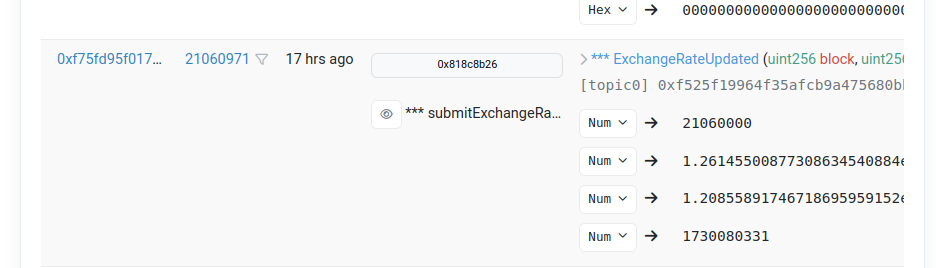

In [37]:
100 * (15_000 / 12_000_000)

0.125

In [2]:
from mainnet_launch.constants import CACHE_TIME, ALL_AUTOPOOLS, eth_client, LENS_CONTRACT
from mainnet_launch.data_fetching.get_state_by_block import (
    get_raw_state_by_blocks,
    get_state_by_one_block,
    identity_with_bool_success,
    safe_normalize_with_bool_success,
    build_blocks_to_use,
)


def _clean_summary_stats_info(success, summary_stats):
    if success is True:
        summary = {
            "destination": summary_stats[0],
            "baseApr": summary_stats[1] / 1e18,
            "feeApr": summary_stats[2] / 1e18,
            "incentiveApr": summary_stats[3] / 1e18,
            "safeTotalSupply": summary_stats[4] / 1e18,
            "priceReturn": summary_stats[5] / 1e18,
            "maxDiscount": summary_stats[6] / 1e18,
            "maxPremium": summary_stats[7] / 1e18,
            "ownedShares": summary_stats[8] / 1e18,
            "compositeReturn": summary_stats[9] / 1e18,
            "pricePerShare": summary_stats[10] / 1e18,
        }
        return summary
    else:
        return None


def build_proxyGetDestinationSummaryStats_call(
    name: str, autopool_strategy_address: str, destination_address: str, direction: str, amount: int
) -> Call:
    if direction == "in":
        direction_enum = 0
    elif direction == "out":
        direction_enum = 1
    else:
        raise ValueError(f"direction can only be `in` or `out` is {direction=}")

    return Call(
        LENS_CONTRACT,
        [
            f"proxyGetDestinationSummaryStats(address,address,uint8,uint256)((address,uint256,uint256,uint256,uint256,int256,int256,int256,uint256,int256,uint256))",
            autopool_strategy_address,
            destination_address,
            direction_enum,
            amount,
        ],
        [(name, _clean_summary_stats_info)],
    )


def build_all_proxyGetDestinationSummaryStats_calls(autopool: AutopoolConstants) -> list[Call]:
    destination_details = get_destination_details()
    all_of_this_autopools_destinations = [dest for dest in destination_details if dest.autopool == autopool]
    # include a check that the unqiue vaultAddress == len(all_of_this_autopools_destinations)

    calls = [
        build_proxyGetDestinationSummaryStats_call(
            name=dest.vaultAddress,
            autopool_strategy_address=dest.autopool.autopool_eth_strategy_addr,
            destination_address=dest.vaultAddress,
            direction="out",
            amount=0,
        )
        for dest in all_of_this_autopools_destinations
    ]  # for each autopool the destination vault address is unique

    return calls


def fetch_destination_summary_stats(blocks: list[int], autopool: AutopoolConstants):
    calls = build_all_proxyGetDestinationSummaryStats_calls(autopool)

    calls.append(get_pools_and_destinations_call())
    summary_stats_df = get_raw_state_by_blocks(calls, blocks)

    return summary_stats_df


# I think this works but the warnings are a problem, need to fix unsure how
blocks = build_blocks_to_use()
df = fetch_destination_summary_stats(blocks, AUTO_LRT)
df

2024-10-11 19:38:44.221 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-11 19:38:44.222 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-11 19:38:44.222 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-11 19:38:44.223 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-11 19:38:44.223 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-11 19:38:44.224 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-11 19:38:44.224 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-11 19:38:44.225 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

,0x1416bfe53520a71553230c3fdeeece30d5470ba7,0x40219bbda953ca811d2d0168dc806a96b84791d9,0x148ca723befea7b021c399413b8b7426a4701500,0x689dc7b5ce8e23061a8223e97701e9345764b8b7,0x17216c32b9134343258b05807405db02be030acd,0x3b2c87ed95483059b950155a68e906d543193d5c,0x4e12227b350e8f8feec41a58d36ce2fb2e2d4575,0x676b34c2c2294ef070c1e9e0fcd4091dd06393fe,0x2f2cc1bf461413014741dd68481db4a3686dac3d,0x90300b02b162f902b9629963830bcccdeed71113,0x5c6aeb9ef0d5bba4e6691f381003503fd0d45126,0xc4c973edc82cb6b972c555672b4e63713c177995,0x2f7e096a400ded5d02762120b39a3aa4aba072a4,0xc9b5d82652a1c8214b0971a004983d0eeedd751c,0x777faf85c8e5fc6f4332e56b989c5c94201a273c,0xE800e3760FC20aA98c5df6A9816147f190455AF3,0xb6d68122428dc1141467cb96791618615ab9f746,getPoolsAndDestinations
timestamp,,,,,,,,,,,,,,,,,,
2024-09-15 02:04:47,{'destination': '0x1416bfe53520a71553230c3fdee...,None,None,{'destination': '0x689dc7b5ce8e23061a8223e9770...,{'destination': '0x17216c32b9134343258b0580740...,{'destination': '0x3b2c87ed95483059b950155a68e...,None,{'destination': '0x676b34c2c2294ef070c1e9e0fcd...,None,None,None,None,None,None,None,{'destination': '0xe800e3760fc20aa98c5df6a9816...,{'destination': '0xb6d68122428dc1141467cb96791...,{'autopools': [{'poolAddress': '0x0a2b94f6871c...
2024-09-15 05:44:35,{'destination': '0x1416bfe53520a71553230c3fdee...,None,None,{'destination': '0x689dc7b5ce8e23061a8223e9770...,{'destination': '0x17216c32b9134343258b0580740...,{'destination': '0x3b2c87ed95483059b950155a68e...,None,{'destination': '0x676b34c2c2294ef070c1e9e0fcd...,None,None,None,None,None,None,None,{'destination': '0xe800e3760fc20aa98c5df6a9816...,{'destination': '0xb6d68122428dc1141467cb96791...,{'autopools': [{'poolAddress': '0x0a2b94f6871c...
2024-09-15 09:24:47,{'destination': '0x1416bfe53520a71553230c3fdee...,None,None,{'destination': '0x689dc7b5ce8e23061a8223e9770...,{'destination': '0x17216c32b9134343258b0580740...,{'destination': '0x3b2c87ed95483059b950155a68e...,None,{'destination': '0x676b34c2c2294ef070c1e9e0fcd...,None,None,None,None,None,None,None,{'destination': '0xe800e3760fc20aa98c5df6a9816...,{'destination': '0xb6d68122428dc1141467cb96791...,{'autopools': [{'poolAddress': '0x0a2b94f6871c...
2024-09-15 13:04:11,{'destination': '0x1416bfe53520a71553230c3fdee...,None,None,{'destination': '0x689dc7b5ce8e23061a8223e9770...,{'destination': '0x17216c32b9134343258b0580740...,{'destination': '0x3b2c87ed95483059b950155a68e...,None,{'destination': '0x676b34c2c2294ef070c1e9e0fcd...,None,None,None,None,None,None,None,{'destination': '0xe800e3760fc20aa98c5df6a9816...,{'destination': '0xb6d68122428dc1141467cb96791...,{'autopools': [{'poolAddress': '0x0a2b94f6871c...
2024-09-15 16:44:23,{'destination': '0x1416bfe53520a71553230c3fdee...,None,{'destination': '0x148ca723befea7b021c399413b8...,{'destination': '0x689dc7b5ce8e23061a8223e9770...,{'destination': '0x17216c32b9134343258b0580740...,{'destination': '0x3b2c87ed95483059b950155a68e...,{'destination': '0x4e12227b350e8f8feec41a58d36...,{'destination': '0x676b34c2c2294ef070c1e9e0fcd...,None,{'destination': '0x90300b02b162f902b9629963830...,None,{'destination': '0xc4c973edc82cb6b972c555672b4...,{'destination': '0x2f7e096a400ded5d02762120b39...,None,{'destination': '0x777faf85c8e5fc6f4332e56b989...,{'destination': '0xe800e3760fc20aa98c5df6a9816...,{'destination': '0xb6d68122428dc1141467cb96791...,{'autopools': [{'poolAddress': '0x0a2b94f6871c...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-11 08:40:59,{'destination': '0x1416bfe53520a71553230c3fdee...,{'destination': '0x40219bbda953ca811d2d0168dc8...,{'destination': '0x148ca723befea7b021c399413b8...,{'destination': '0x689dc7b5ce8e23061a8223e9770...,{'destination': '0x17216c32b9134343258b0580740...,{'destination': '0x3b2c87ed95483059b950155a68e...,{'destination': '0x4e12227b350e8f8feec41a58d36...,{'destination': '0x676b34c2c2294ef070c1e9e0fcd...,{'destination': '0x2f2cc1bf461413014741dd68481...,{'destination': '0x90300b02b162f902b9629963830...,

In [3]:
all_of_this_autopools_destinations = [dest for dest in destination_details if dest.autopool == AUTO_LRT]
duplciated_pool = [
    a
    for a in all_of_this_autopools_destinations
    if a.vault_name == "Tokemak-Wrapped Ether-Balancer rsETH-WETH Stable Pool"
]
duplciated_pool

[Destination Details:
  Vaultaddress        	: 0x4e12227b350e8f8feec41a58d36ce2fb2e2d4575
  Exchangename        	: balancer
  Dexpool             	: 0x58aadfb1afac0ad7fca1148f3cde6aedf5236b6d
  Lptokenaddress      	: 0x58aadfb1afac0ad7fca1148f3cde6aedf5236b6d
  Lptokensymbol       	: rsETH / WETH
  Lptokenname         	: Balancer rsETH-WETH Stable Pool
  Autopool            	: {'name': 'autoLRT', 'autopool_eth_addr': '0xE800e3760FC20aA98c5df6A9816147f190455AF3', 'autopool_eth_strategy_addr': '0x72a726c10220280049687E58B7b05fb03d579109', 'solver_rebalance_plans_bucket': 'v2-gen3-eth-mainnet-solve-v2gen3ethmainnetsolverau-cb9s4hq4f8sv'}
  Vault_Name          	: Tokemak-Wrapped Ether-Balancer rsETH-WETH Stable Pool,
 Destination Details:
  Vaultaddress        	: 0x676b34c2c2294ef070c1e9e0fcd4091dd06393fe
  Exchangename        	: balancer
  Dexpool             	: 0x58aadfb1afac0ad7fca1148f3cde6aedf5236b6d
  Lptokenaddress      	: 0x58aadfb1afac0ad7fca1148f3cde6aedf5236b6d
  Lptokensymbol  

In [4]:
import warnings
from IPython.display import clear_output

destination_vault_address_cols = [d for d in df.columns if d != "getPoolsAndDestinations"]


def _replace_destination_summary_stats_of_destinations_not_linked_to_any_autopool_with_none(row: pd.Series) -> dict:
    # if a destination_vault is currently is the destinations returned by lens_contract.getPoolsAndDestinations() at that block
    # keep the data
    # otherwise set it to None

    # this is so that we only look at data for active destinations.
    # the isShutdown() method on DestinationVault is not used here.
    # 0x4e12227b350e8f8feec41a58d36ce2fb2e2d4575 0x676b34c2c2294ef070c1e9e0fcd4091dd06393fe are eact not shudown
    # but only one is actively allocated to. the other was deprecated
    # this logic is complicated. double check that it makes sense with cody

    # excess caching warnings here
    row_dict = row.to_dict()

    current_destination_vault_addresses = set()
    for list_of_destinations in row_dict["getPoolsAndDestinations"]["destinations"]:
        for destination in list_of_destinations:
            current_destination_vault_addresses.add(destination["vaultAddress"])

    clean_destination_summary_stats = dict()
    for destination_vault_address in destination_vault_address_cols:
        if destination_vault_address in current_destination_vault_addresses:
            vault_name = attempt_destination_address_to_vault_name(destination_vault_address)
            if vault_name in clean_destination_summary_stats:
                raise ValueError("should attempt to have more than one destination summary stat per destination")
            clean_destination_summary_stats[vault_name] = row_dict[destination_vault_address]

    return clean_destination_summary_stats


with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    clean_df = pd.DataFrame.from_records(
        df.apply(_replace_destination_summary_stats_of_destinations_not_linked_to_any_autopool_with_none, axis=1)
    )
    clear_output(wait=True)
    clean_df

2024-10-11 19:38:48.425 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-11 19:38:48.425 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-11 19:38:48.426 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-11 19:38:48.426 No runtime found, using MemoryCacheStorageManager
2024-10-11 19:38:48.427 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-11 19:38:48.427 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-11 19:38:48.427 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-11 19:38:48.428 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-11 19:38:48.429 Thread 'MainThread':

In [5]:
clean_df

,Tokemak-Wrapped Ether-Balancer weETH/ezETH/rswETH,Tokemak-Wrapped Ether-Balancer ezETH-WETH Stable Pool,Tokemak-Wrapped Ether-weETH/WETH-ng,Tokemak-Wrapped Ether-Balancer weETH/rETH StablePool,Tokemak-Wrapped Ether-Balancer rsETH-WETH Stable Pool,Tokemak-Wrapped Ether-Balancer rsETH / ETHx
0,{'destination': '0x1416bfe53520a71553230c3fdee...,{'destination': '0x689dc7b5ce8e23061a8223e9770...,{'destination': '0x17216c32b9134343258b0580740...,{'destination': '0x3b2c87ed95483059b950155a68e...,{'destination': '0x676b34c2c2294ef070c1e9e0fcd...,{'destination': '0xb6d68122428dc1141467cb96791...
1,{'destination': '0x1416bfe53520a71553230c3fdee...,{'destination': '0x689dc7b5ce8e23061a8223e9770...,{'destination': '0x17216c32b9134343258b0580740...,{'destination': '0x3b2c87ed95483059b950155a68e...,{'destination': '0x676b34c2c2294ef070c1e9e0fcd...,{'destination': '0xb6d68122428dc1141467cb96791...
2,{'destination': '0x1416bfe53520a71553230c3fdee...,{'destination': '0x689dc7b5ce8e23061a8223e9770...,{'destination': '0x17216c32b9134343258b0580740...,{'destination': '0x3b2c87ed95483059b950155a68e...,{'destination': '0x676b34c2c2294ef070c1e9e0fcd...,{'destination': '0xb6d68122428dc1141467cb96791...
3,{'destination': '0x1416bfe53520a71553230c3fdee...,{'destination': '0x689dc7b5ce8e23061a8223e9770...,{'destination': '0x17216c32b9134343258b0580740...,{'destination': '0x3b2c87ed95483059b950155a68e...,{'destination': '0x676b34c2c2294ef070c1e9e0fcd...,{'destination': '0xb6d68122428dc1141467cb96791...
4,{'destination': '0x90300b02b162f902b9629963830...,{'destination': '0xc4c973edc82cb6b972c555672b4...,{'destination': '0x777faf85c8e5fc6f4332e56b989...,{'destination': '0x148ca723befea7b021c399413b8...,{'destination': '0x4e12227b350e8f8feec41a58d36...,{'destination': '0x2f7e096a400ded5d02762120b39...
...,...,...,...,...,...,...
172,{'destination': '0xc9b5d82652a1c8214b0971a0049...,{'destination': '0x2f2cc1bf461413014741dd68481...,{'destination': '0x5c6aeb9ef0d5bba4e6691f38100...,{'destination': '0x40219bbda953ca811d2d0168dc8...,{'destination': '0x4e12227b350e8f8feec41a58d36...,{'destination': '0x2f7e096a400ded5d02762120b39...
173,{'destination': '0xc9b5d82652a1c8214b0971a0049...,{'destination': '0x2f2cc1bf461413014741dd68481...,{'destination': '0x5c6aeb9ef0d5bba4e6691f38100...,{'destination': '0x40219bbda953ca811d2d0168dc8...,{'destination': '0x4e12227b350e8f8feec41a58d36...,{'destination': '0x2f7e096a400ded5d02762120b39...
174,{'destination': '0xc9b5d82652a1c8214b0971a0049...,{'destination': '0x2f2cc1bf461413014741dd68481...,{'destination': '0x5c6aeb9ef0d5bba4e6691f38100...,{'destination': '0x40219bbda953ca811d2d0168dc8...,{'destination': '0x4e12227b350e8f8feec41a58d36...,{'destination': '0x2f7e096a400ded5d02762120b39...
175,{'destination': '0xc9b5d82652a1c8214b0971a0049...,{'destination': '0x2f2cc1bf461413014741dd68481...,{'destination': '0x5c6aeb9ef0d5bba4e6691f38100...,{'destination': '0x40219bbda953ca811d2d0168dc8...,{'destination': '0x4e12227b350e8f8feec41a58d36...,{'destination': '0x2f7e096a400ded5d02762120b39...


In [6]:
col1 = "0x4e12227b350e8f8feec41a58d36ce2fb2e2d4575"
col2 = "0x676b34c2c2294ef070c1e9e0fcd4091dd06393fe"
import numpy as np

limited_df = clean_df[[col1, col2]].copy()
limited_df["0x676b34c2c2294ef070c1e9e0fcd4091dd06393fe"].iloc[0]

KeyError: "None of [Index(['0x4e12227b350e8f8feec41a58d36ce2fb2e2d4575', '0x676b34c2c2294ef070c1e9e0fcd4091dd06393fe'], dtype='object')] are in the [columns]"

In [ ]:
col1 = "0x4e12227b350e8f8feec41a58d36ce2fb2e2d4575"
col2 = "0x676b34c2c2294ef070c1e9e0fcd4091dd06393fe"
import numpy as np

limited_df = clean_df[[col1, col2]].copy()
limited_df
np.all(limited_df.isna().sum(axis=1) == 1)
# one option is to inlude a is shutdown call on each of the destinations

In [ ]:
# [[0x2f2CC1bf461413014741dD68481dB4a3686DAC3D]
# [0x40219bBda953ca811d2D0168Dc806a96b84791d9]
# [0xC9b5D82652a1C8214b0971A004983d0EEeDD751C]
# [0x4E12227b350E8f8fEEc41A58D36cE2fB2e2d4575]
# [0x2F7e096a400ded5D02762120b39A3aA4ABA072a4]
# [0x5c6aeb9ef0d5BbA4E6691f381003503FD0D45126]]

# I need to know when in conflict, which reponse to use from  proxyGetDestinationSummaryStats

# I want a (autopool, block) -> list of current destinations

In [ ]:
limited_df

In [ ]:
dest = destination_details[5]
print(dest)

In [ ]:
break

In [ ]:
build_proxyGetDestinationSummaryStats_call(
    "destination_details",
)

In [ ]:
c = build_proxyGetDestinationSummaryStats_call()

In [ ]:
print(destination_details[4])

In [ ]:
# /// @param destination The address / lp token of the destination vault
# /// @param baseApr Base Apr is the yield generated by staking rewards
# /// @param feeApr Yield for pool trading fees
# /// @param incentiveApr Incentives for LP
# /// @param safeTotalSupply Safe supply for LP tokens
# /// @param priceReturn Return from price movement to & away from peg
# /// @param maxDiscount Max discount to peg
# /// @param maxPremium Max premium to peg
# /// @param ownedShares Shares owned for this destination
# /// @param compositeReturn Total return combined from the individual yield components
# /// @param pricePerShare Price per share
# struct SummaryStats {
#     address destination;
#     uint256 baseApr;
#     uint256 feeApr;
#     uint256 incentiveApr;
#     uint256 safeTotalSupply;
#     int256 priceReturn;
#     int256 maxDiscount;
#     int256 maxPremium;
#     uint256 ownedShares;
#     int256 compositeReturn;
#     uint256 pricePerShare;
# }

# /// @dev Returns a destinations summary stats. Can revert and there can be abi decode errors temporarily
# /// @param autopoolStrategy Strategy to query
# /// @param destinationAddress Address of the destination to query stats for
# /// @param direction Direction to calculate the stats for
# /// @param amount Amount to use when looking at dilution effects
# /// @return stats The Destinations summary stats from the Strategy
# function proxyGetDestinationSummaryStats(
#     IAutopoolStrategy autopoolStrategy,
#     address destinationAddress,
#     IAutopoolStrategy.RebalanceDirection direction,
#     uint256 amount
# ) public returns (IStrategy.SummaryStats memory) {
#     return autopoolStrategy.getDestinationSummaryStats(destinationAddress, direction, amount);
# }

In [ ]:
calls = []
for autopool in ALL_AUTOPOOLS:
    for dest in destination_details:
        if autopool.autopool_eth_addr == dest.autopool_vault_address:
            print(dest)

In [ ]:
_build_summary_stats_call()

In [ ]:
import pandas as pd
from mainnet_launch.constants import (
    CACHE_TIME,
    eth_client,
    ALL_AUTOPOOLS,
    BAL_ETH,
    AUTO_ETH,
    AUTO_LRT,
    AutopoolConstants,
)
from mainnet_launch.abis.abis import AUTOPOOL_VAULT_ABI
from mainnet_launch.data_fetching.get_events import get_each_event_in_contract


vault_contract = eth_client.eth.contract(AUTO_ETH.autopool_eth_addr, abi=AUTOPOOL_VAULT_ABI)

events = get_each_event_in_contract(vault_contract)
for e, df in events.items():
    print(e, df.shape)

In [ ]:
# def _clean_summary_stats_info(success, summary_stats):
#     if success is True:
#         summary = {
#             "destination": summary_stats[0],
#             "baseApr": summary_stats[1] / 1e18,
#             "feeApr": summary_stats[2] / 1e18,
#             "incentiveApr": summary_stats[3] / 1e18,
#             "safeTotalSupply": summary_stats[4] / 1e18,
#             "priceReturn": summary_stats[5] / 1e18,
#             "maxDiscount": summary_stats[6] / 1e18,
#             "maxPremium": summary_stats[7] / 1e18,
#             "ownedShares": summary_stats[8] / 1e18,
#             "compositeReturn": summary_stats[9] / 1e18,
#             "pricePerShare": summary_stats[10] / 1e18,
#             # ignoring slashings costs, no longer part of model
#         }
#         return summary
#     else:
#         return None

# def build_proxyGetDestinationSummaryStats_call(
#         name:str, autopool_strategy_address :str, destination_address: str, direction:str, amount:int) -> Call:
#     if direction == "in":
#         direction_enum = 0
#     elif direction == "out":
#         direction_enum = 1
#     return_types = "(address,uint256,uint256,uint256,uint256,int256,int256,int256,uint256,int256,uint256)"

#     # cleaning_function = build_summary_stats_cleaning_function(autopool)
#     return Call(
#         LENS_CONTRACT,
#         [
#             f"proxyGetDestinationSummaryStats(address,address,uint8,uint256)({return_types})",
#             autopool_strategy_address,
#             destination_address,
#             direction_enum,
#             amount,
#         ],
#         [(name, _clean_summary_stats_info)],
#     )

In [ ]:
s = events["Withdraw"]

s.sort_values("shares").tail(2).value_counts()

In [ ]:
deposits = events["Deposit"]
deposits.tail(5).value_counts()

In [ ]:
# https://dashboard.tenderly.co/tx/mainnet/0x030ca18bd0d52298ff9c49b76b100d0b2150cc9327392e720bc9f742ab1f6186
# deposit and stake .007 ETH, through the front end multicall. slightly more if you are using ETH instead of WETH.

# 281k Gas for a deposit, and stake of ETH

# 189k for Withdrawal, when fully in idle.

# about 400k gas when depositing to and from idle
# 0xf0a909c99aa33d45890d4f908d12301678ec3c1d78c52fc30d063961a4952d66
# at current prices is $21 round trip. Note this matches what I experienced, it cost ~$20 when I did it at the start
# https://www.cryptoneur.xyz/en/gas-fees-calculator?usedGas=400000&txnType=Custom

# our target user is entering and exit only from idle, so

# 400k Gas to enter and exit from idle, at 20 gwei and ETH at $2400, a round trip is $20.
# Curve add liqudity, 180k gas https://etherscan.io/tx/0x941010536a0c32db51275784e7a7e5f65e578867abcc87e0fe0c1f01af0490da
# Curve withdrawal liqudity 178,725 https://etherscan.io/tx/0x941010536a0c32db51275784e7a7e5f65e578867abcc87e0fe0c1f01af0490da

# curve depoist to gauge 445,888 gas https://etherscan.io/tx/0xabdf03ee23049df07cfb161db7bcba555e022822f397f5744e3b9f8c3e223c09
# Curve withdrawal from gauge 390,108 gas https://etherscan.io/tx/0x7dfcdcd40962a2b71251de0021c13602583cc99a9e2016b13c60f9891b96cefd

# convex stake https://etherscan.io/tx/0x3538805f314ccb033668aff57fcd85c21109cc5d57268500a7b79b79f133e334
# 600,278 gas
# convex unstake https://dashboard.tenderly.co/tx/mainnet/0xba77cb7da59cfd50635a32f2b32cac5b3608cf1993a3e9b278cf91818d56b250
# 520k gas


# total gas 1194K gas for add liqudity, stake on convex, unstake on convex, remove liqudity
# then they need to pay gas to claim rewards,

# 180 + 178 + 600 + 520

# lets looks look at some typical paths

# user added liqudity on curve, stakes it on convex,

# claims rewards once, having a hard time finding this transaction

# unstake on convex,  remove liqudity

# swap back to ETH

In [ ]:
352 + 105 + 345 + 241 + 188

In [ ]:
180 + 178 + 600 + 520

In [ ]:
import pandas as pd
from mainnet_launch.constants import (
    CACHE_TIME,
    eth_client,
    ALL_AUTOPOOLS,
    BAL_ETH,
    AUTO_ETH,
    AUTO_LRT,
    AutopoolConstants,
)
from mainnet_launch.solver_diagnostics.solver_diagnostics import _load_solver_df


solver_df = _load_solver_df(AUTO_ETH)
sod = None
destination_added_to = None


def _get_rank_of_add(row: dict):
    sod = row["sod"]
    destination_added_to = row["destinationIn"]
    return


solver_df.apply(lambda row: _get_rank_of_add(row), axis=1)
destination_added_to

In [ ]:
states = pd.DataFrame.from_records(solver_df["sod"].values[0]["destStates"])
states["name"]

In [ ]:
solver_df.columns

In [ ]:
states.columns

In [ ]:
solver_df.head(1).T

In [ ]:
solver_df.columns

In [ ]:
states["pool"]

In [ ]:
solver_df.columns

In [ ]:
solver_df.head(1)[["destinationOut"]]

In [ ]:
solver_df.head(1)[["destinationIn"]]

In [ ]:
states[["name", "totalAprIn", "pool"]]

In [ ]:
states.columns

In [ ]:
all_steps = solver_df["steps"].values
dex_steps = []
for steps in all_steps:
    for step in steps:
        if "dex" in step:
            dex_steps.append(step)
pd.DataFrame.from_records(dex_steps)["dex"].value_counts()

In [ ]:
def compute_number_of_add_rank_def(row: dict):
    addRank = row["addRank"]


solver_df

In [ ]:
solver_df["addRank"].values[0]
# 1st no. should be the predicted ETH gain net of swap costs, 2nd no. is the swap costs. the results are highly dependent on the swap path that aggregators find

In [ ]:
solver_df["moveName"][0]

In [ ]:
# Ensure that the 'date' column is in datetime format
solver_df["date"] = pd.to_datetime(solver_df["date"])

# Group by date and check if there is at least one row for each day
days_with_data = solver_df.groupby(solver_df["date"].dt.date).size() > 0

# Convert it to a DataFrame or Series to display the result
days_with_data_df = pd.DataFrame(days_with_data, columns=["Solver Ran At Least"])
days_with_data_df

In [ ]:
import plotly.express as px

In [ ]:
solver_df["date"]

In [ ]:
contract = eth_client.eth.contract(BAL_ETH.autopool_eth_addr, abi=ERC_20_ABI)
events = get_each_event_in_contract(contract)

In [ ]:
transfers = events["Transfer"]
transfers

In [ ]:
transfers = transfers.sort_values("block", ascending=False)

In [ ]:
def build_wallet_balance_at_the_end_of_each_block(token_address: str) -> pd.DataFrame:
    # returns a dataframe of the balance of each token at the end of each block
    # breaks if a token_address is rebasing, or if balances can change while not emitting a transfer event

    contract = eth_client.eth.contract(token_address, abi=ERC_20_ABI)
    transfers = fetch_events(contract.events.Transfer)
    all_wallets = set(transfers["to"].unique())
    blocks = transfers["block"].unique().astype(int)
    block_and_timestamp_df = get_raw_state_by_blocks([], blocks, include_block_number=True).reset_index()

    def build_state_change(row: dict):
        amount = float(int(row["value"]) / 1e18)
        changes = {
            row["to"]: amount,
            row["from"]: -amount,
            "block": row["block"],
        }

        for w in all_wallets:
            if w not in changes:
                changes[w] = 0.0
        return changes

    rolling_wallet_erc20_balance_by_block = pd.DataFrame.from_records(
        transfers.sort_values("block", ascending=False).apply(build_state_change, axis=1)
    )
    rolling_wallet_erc20_balance_by_block = (
        rolling_wallet_erc20_balance_by_block.groupby("block").sum().cumsum().reset_index()
    )
    rolling_wallet_erc20_balance_by_block = pd.merge(
        rolling_wallet_erc20_balance_by_block, block_and_timestamp_df, on="block", how="left"
    )
    rolling_wallet_erc20_balance_by_block.set_index("timestamp", inplace=True)
    return rolling_wallet_erc20_balance_by_block


rolling_wallet_erc20_balance_by_block = build_wallet_balance_at_the_end_of_each_block(AUTO_LRT.autopool_eth_addr)
rolling_wallet_erc20_balance_by_block

In [ ]:
addresses_to_exclude = [
    "0x0000000000000000000000000000000000000000",
    *[a.autopool_eth_addr for a in ALL_AUTOPOOLS],
    "0x000000000000000000000000000000000000dEaD",
    "0x9597C17f323160D8462c194D72FAAcF7b4CBCd2b",  # main rewarder
    "0xC45e939ca8C43822A2A233404Ecf420712084c30",  # router
]

cols = [c for c in rolling_wallet_erc20_balance_by_block.columns if c not in ["block", *addresses_to_exclude]]

In [ ]:
def _daily_balance_over_zero(group):

    for value in group:
        if value > 0.0:
            return True

    return False


balance_lists = rolling_wallet_erc20_balance_by_block[cols].resample("1D").apply(list).map(_daily_balance_over_zero)

balance_lists.sum(axis=1)

In [ ]:
rolling_wallet_erc20_balance_by_block.resample("1D").apply(list)

In [ ]:
# had some balance within the last d ay

In [ ]:
rolling_wallet_erc20_balance_by_block.columns.sort_values()

In [ ]:
def get_count_of_balance_above_zero(row:dict):
    print(row.keys())

    
    addresses
    for addr in row:
        if addr not in :
            pass
            
    
    return   

rolling_wallet_erc20_balance_by_block.apply(get_count_of_balance_above_zero, axis=1)

In [ ]:
dfs = [_fetch_raw_deposit_and_withdrawal_dfs(a) for a in ALL_AUTOPOOLS]
dfs

In [ ]:
d, w = dfs[0]
d["sender"].value_counts()

In [ ]:
d["owner"].value_counts()